# Recreating baseline models

>Garcia-Ceja, E., Riegler, M., Jakobsen, P., Tørresen, J., Nordgreen, T., Oedegaard, K.J. and Fasmer, O.B. (2018) Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In: Proceedings of the 9th ACM Multimedia Systems Conference [online]MMSys ’18: 9th ACM Multimedia Systems Conference. Amsterdam Netherlands: ACM, pp. 472–477. Available from: https://dl.acm.org/doi/10.1145/3204949.3208125 [Accessed 2 December 2023].

**Objective**

* Recreating baseline models in the above article

## Preprocessing

* Minimal preprocessing

In [1]:
# import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Extract data from folder

In [2]:

def extract_from_folder(folderpath, downsample=None, save_to_csv=False, output_csv_path=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): folder containing CSV files.
      downsample (int, optional): number of rows to downsample CSVs to. Defaults to None.
      save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
      output_csv_path (str, optional): csv filepath. required if save_to_csv is True.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # optional downsample 
                if downsample:
                    df = df.sample(downsample)

                # ID column - this is the filename without the extension
                df['id'] = id

                # 'condition' column
                df['condition'] = subfolder

                # convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)


    try:
        if save_to_csv:
            if output_csv_path:
                df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return df
    except OSError:
        print("Error saving to CSV.")


In [3]:
folderpath = '../data/depresjon'


# full ds, no csv
df = extract_from_folder(folderpath)


### Data reduction (as per `scores.csv`)

For this baseline model, I am extracting the `number of days` as per the `scores.csv` dataset.  In the interests of keeping things simple, I am not performing any other data preprocessing (no normalisation, no additional features, no ensuring complete days (1440 rows)).

In [4]:
import pandas as pd

def extract_days_per_scores(df, scores_csv_path='..\data\depresjon\scores.csv', save_to_csv=True, output_csv_path=None):
    """
    Extract the number of days per ID from the 'scores' data.

    Args:
        df (pd.DataFrame): df containing the 'id' column.
        scores_csv_path (str, optional): path to the 'scores' CSV file. Defaults to '..\data\depresjon\scores.csv'.
        save_to_csv (bool, optional): save the updated df to a CSV file? Defaults to True.
        output_csv_path (str, optional): csv filepath. Required if save_to_csv is True.
        

    Returns:
        pd.DataFrame: df with the specified number of days per ID based on 'scores'.
    """
    # scores from the CSV file
    scores_df = pd.read_csv(scores_csv_path)

    # merge scores with the df based on the 'id' column
    merged_df = pd.merge(df, scores_df, left_on='id', right_on='number', how='left')

    # filter rows to keep the specified number of days
    df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)

    # drop cols number, days, gender, age, afftype, melanch, inpatient, edu, marriage, work, madrs1, madrs2
    cols = ['number', 'number', 'days', 'gender', 'age', 'afftype', 'melanch', 'inpatient', 'edu', 'marriage', 'work', 'madrs1', 'madrs2']
    df_filtered.drop(cols, axis=1, inplace=True)
    

    # save to CSV
    if save_to_csv:
        if output_csv_path:
            df_filtered.to_csv(output_csv_path, index=False)
            print(f"\n\ndf saved to {output_csv_path}")
        else:
            print("Error: Please provide an output CSV path.")

    return df_filtered


In [5]:
scores_csv_path = '../data/depresjon/scores.csv'
output_csv_path = '../data/petter/baseline-garcia.csv'

# scores days
garcia = extract_days_per_scores(df, scores_csv_path, save_to_csv=True, output_csv_path=output_csv_path)


C:\Users\zoona\AppData\Local\Temp\ipykernel_29916\242992910.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)




df saved to ../data/petter/baseline-garcia.csv


In [7]:
# print head
#print(garcia.head())

# print shape
#print(garcia.shape)

# print average, min, max, sd days for label 0
print(f"Average number of days for control (label=0): {garcia[garcia['label'] == 0].groupby('id').size().mean()/1440:.2f}")
print(f"SD number of days for control (label=0): {garcia[garcia['label'] == 0].groupby('id').size().std()/1440:.2f}")
print(f"Min number of days for control (label=0): {garcia[garcia['label'] == 0].groupby('id').size().min()/1440:.2f}")
print(f"Max number of days for control (label=0): {garcia[garcia['label'] == 0].groupby('id').size().max()/1440:.2f}")


print("\n")

# print average, min, max, sd days for label 0
print(f"Average number of days for condition (label=1): {garcia[garcia['label'] == 1].groupby('id').size().mean()/1440:.2f}")
print(f"SD number of days for condition (label=1): {garcia[garcia['label'] == 1].groupby('id').size().std()/1440:.2f}")
print(f"Min number of days for condition (label=1): {garcia[garcia['label'] == 1].groupby('id').size().min()/1440:.2f}")
print(f"Max number of days for condition (label=1): {garcia[garcia['label'] == 1].groupby('id').size().max()/1440:.2f}")



Average number of days for control (label=0): 12.56
SD number of days for control (label=0): 2.31
Min number of days for control (label=0): 8.00
Max number of days for control (label=0): 20.00


Average number of days for condition (label=1): 12.65
SD number of days for condition (label=1): 2.77
Min number of days for condition (label=1): 5.00
Max number of days for condition (label=1): 18.00


C:\Users\zoona\AppData\Local\Temp\ipykernel_29916\631304629.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([int(i) for i in plt.gca().get_yticks()/1440])


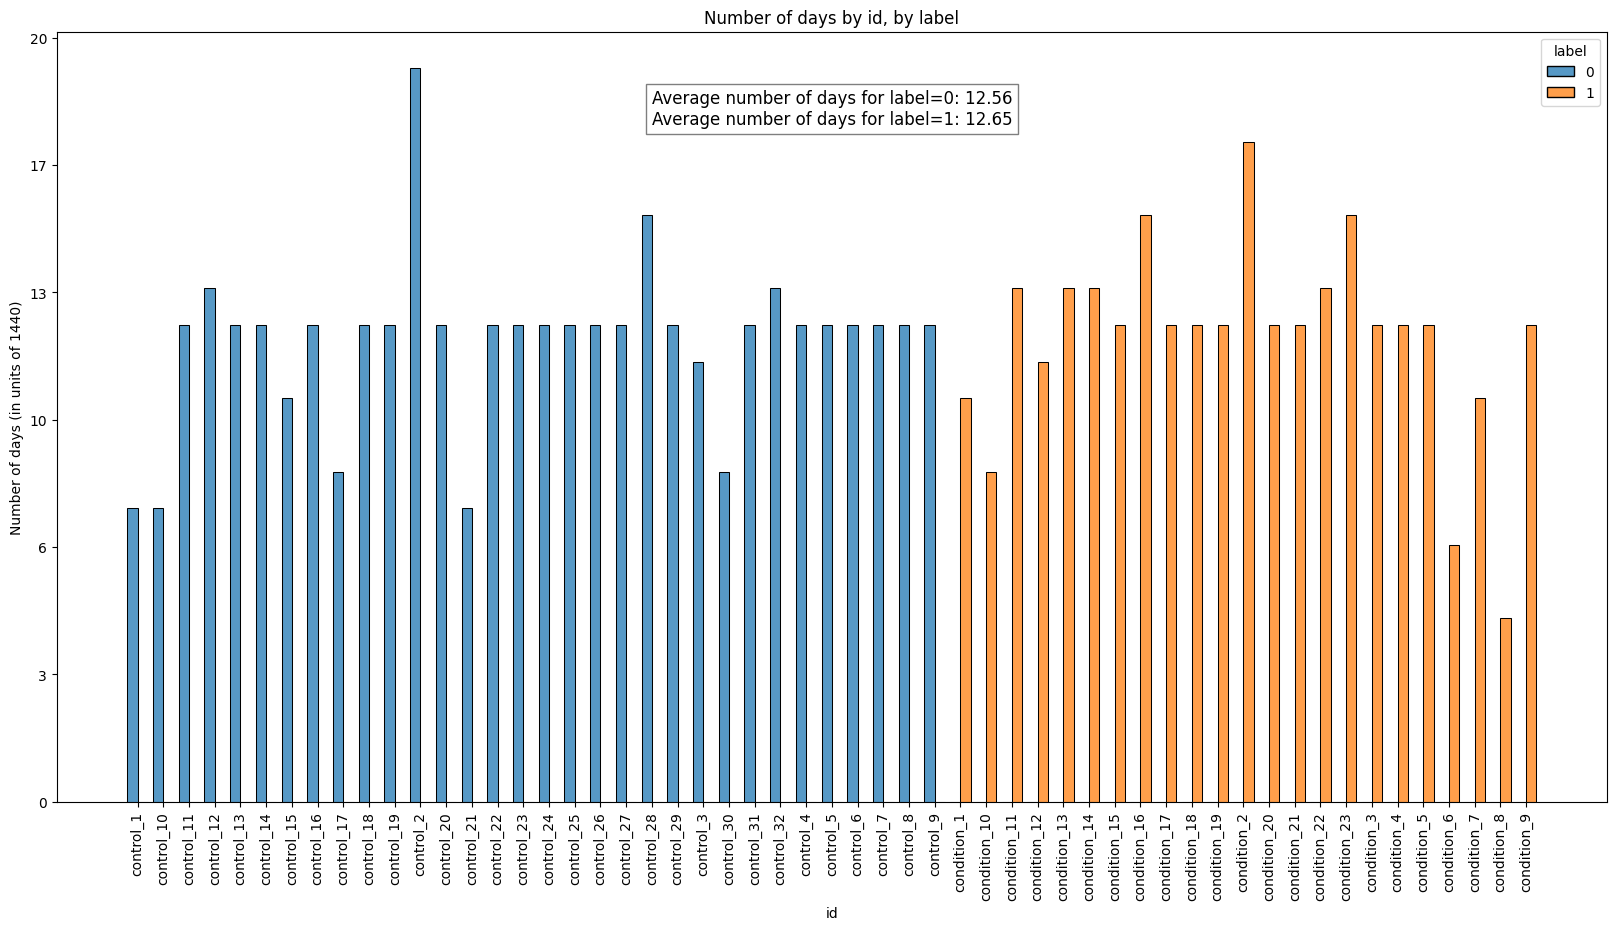

In [8]:

# plot histogram of days by id, by label
plt.figure(figsize=(20,10))
sns.histplot(data=garcia, x='id', hue='label', multiple='dodge', shrink=.8)
plt.title('Number of days by id, by label')
plt.xticks(rotation=90)
plt.xlabel('id')
plt.ylabel('Number of days (in units of 1440)')
plt.gca().set_yticklabels([int(i) for i in plt.gca().get_yticks()/1440])
# add text box with average number of days for each label
plt.text(0.5, 0.9, f"Average number of days for label=0: {garcia[garcia['label'] == 0].groupby('id').size().mean()/1440:.2f}\nAverage number of days for label=1: {garcia[garcia['label'] == 1].groupby('id').size().mean()/1440:.2f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.show()



### Heatmaps

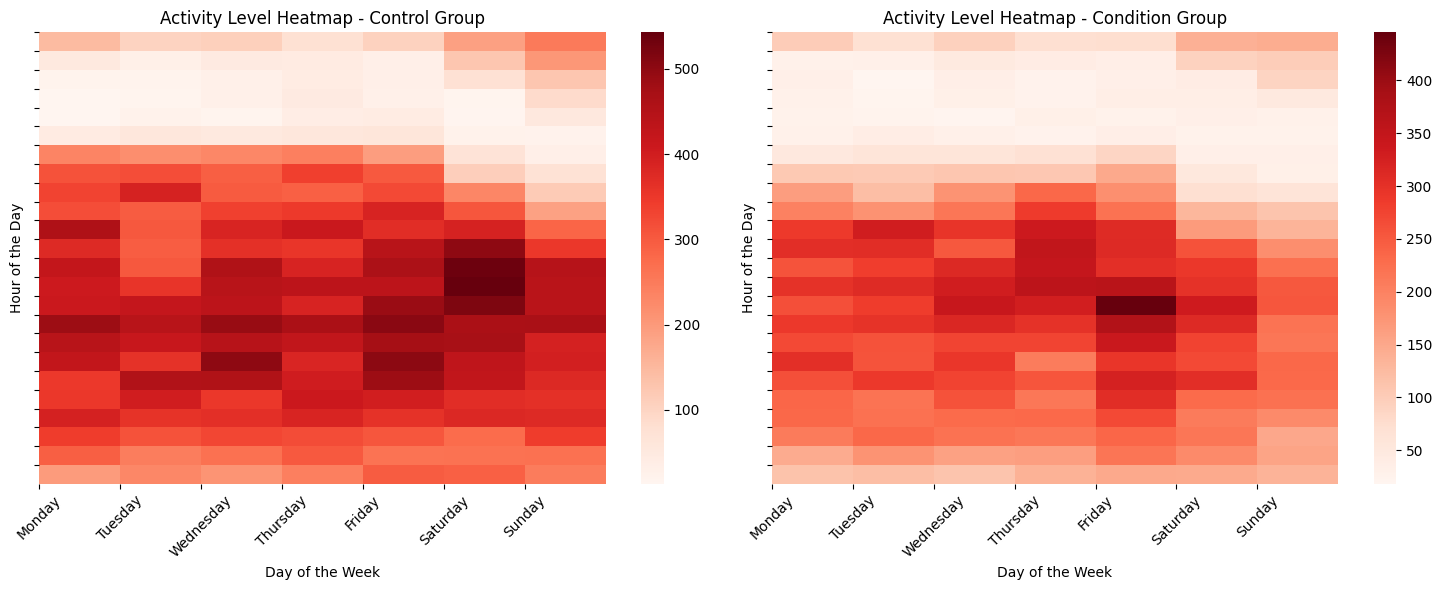

In [38]:
import seaborn as sns
import calendar
import matplotlib.pyplot as plt

# normalise the activity column
scaler = StandardScaler()
garcia['activity_norm'] = scaler.fit_transform(garcia[['activity']])

# extract day of the week (0 = Monday, 6 = Sunday) and hour of the day (0 to 23)
garcia['day_of_week'] = garcia['timestamp'].dt.dayofweek
garcia['hour_of_day'] = garcia['timestamp'].dt.hour

# split df by label 
control = garcia[garcia['label'] == 0]
condition = garcia[garcia['label'] == 1]

# pivot table to reshape the data for the heatmap
control_hm = control.pivot_table(index='hour_of_day', columns='day_of_week', values='activity', aggfunc='mean')
condition_hm = condition.pivot_table(index='hour_of_day', columns='day_of_week', values='activity', aggfunc='mean')

# pivot table to reshape the data for the heatmap - normalised
control_hm_norm = control.pivot_table(index='hour_of_day', columns='day_of_week', values='activity_norm', aggfunc='mean')
condition_hm_norm = condition.pivot_table(index='hour_of_day', columns='day_of_week', values='activity_norm', aggfunc='mean')

# plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# control heatmap
sns.heatmap(control_hm, cmap='Reds', annot=False, fmt='.2f', cbar=True, ax=axs[0])
axs[0].set_xlabel('Day of the Week')
axs[0].set_ylabel('Hour of the Day')
axs[0].set_title('Activity Level Heatmap - Control Group')
axs[0].set_yticks(range(24))
axs[0].set_xticks(range(7))
axs[0].set_xticklabels(calendar.day_name, rotation=45)

# condition heatmap
sns.heatmap(condition_hm, cmap='Reds', annot=False, fmt='.2f', cbar=True, ax=axs[1])
axs[1].set_xlabel('Day of the Week')
axs[1].set_ylabel('Hour of the Day')
axs[1].set_title('Activity Level Heatmap - Condition Group')
axs[1].set_yticks(range(24))
axs[1].set_xticks(range(7))
axs[1].set_xticklabels(calendar.day_name, rotation=45)

plt.tight_layout()
plt.show()


Normalised as per Garcia et al.

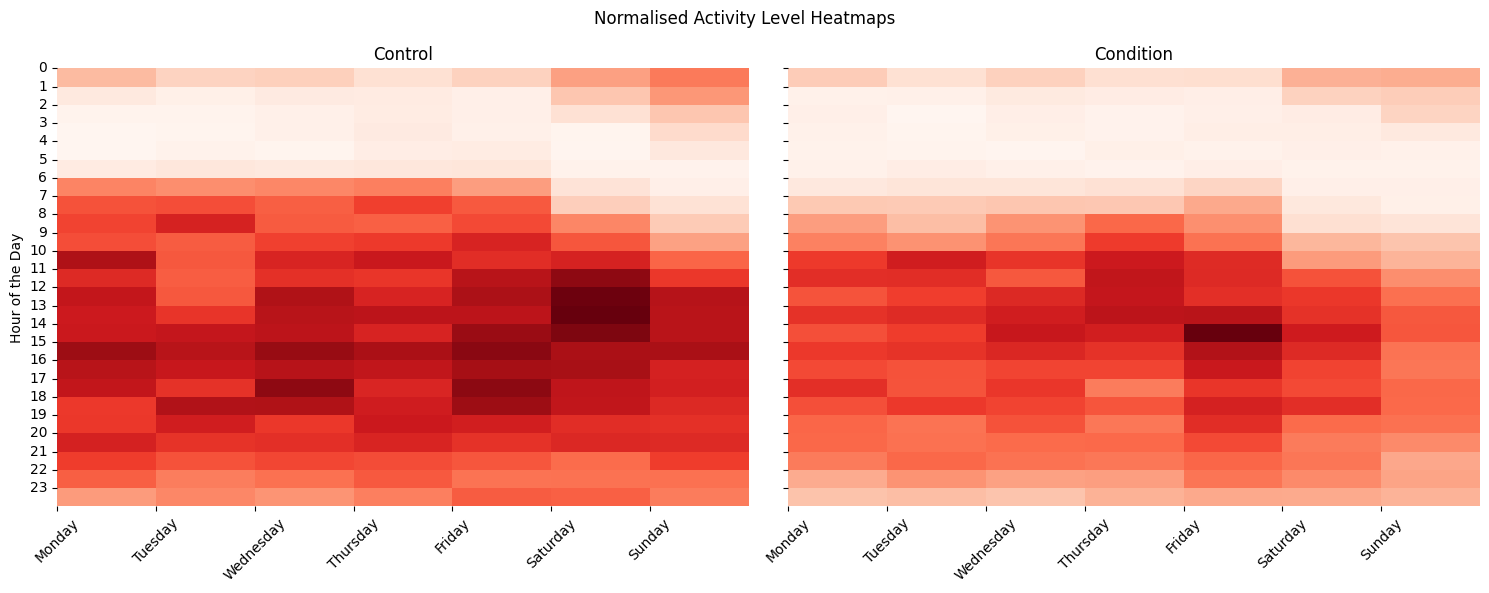

In [55]:
# plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# control heatmap
sns.heatmap(control_hm_norm, cmap='Reds', annot=False, fmt='.2f', cbar=False, ax=axs[0])
#axs[0].set_xlabel('Day of the Week')
axs[0].set_xlabel('')
axs[0].set_ylabel('Hour of the Day')
axs[0].set_title('Control')
axs[0].set_yticks(range(0, 24))
axs[0].set_yticklabels(range(0, 24), rotation=0)  
axs[0].set_xticks(range(7))
axs[0].set_xticklabels(calendar.day_name, rotation=45)

# condition heatmap
sns.heatmap(condition_hm_norm, cmap='Reds', annot=False, fmt='.2f', cbar=False, ax=axs[1])
#axs[1].set_xlabel('Day of the Week')
axs[1].set_xlabel('')
#axs[1].set_ylabel('Hour of the Day')
axs[1].set_ylabel('') 
axs[1].set_title('Condition')
axs[1].set_yticks(range(0, 24))
#axs[1].set_yticklabels(range(0, 24), rotation=0)
axs[1].set_xticks(range(7))
axs[1].set_xticklabels(calendar.day_name, rotation=45)

# add shared title
plt.suptitle('Normalised Activity Level Heatmaps')

plt.tight_layout()
plt.show()

## Baseline Performance

* Nearest Neighbors
* Linear kernel Support Vector Machine (SVM)
* Radial Basis Function kernel (RBF) SVM
* Gaussian Process
* Decision Tree
* Random Forest
* Neural Network
* AdaBoost
* Naive Bayes
* Quadratic Discriminant Analysis (QDA)
* ZeroR

### Train / Test Split

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split


# extract relevant features from timestamp
# garcia['day_of_week'] = garcia['timestamp'].dt.dayofweek
# garcia['hour_of_day'] = garcia['timestamp'].dt.hour

# drop unnecessary columns
X = garcia.drop(['timestamp','label', 'date', 'id'], axis=1)
y = garcia['label']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  set the timestamp as the index:
# X_train.set_index('timestamp', inplace=True)
# X_test.set_index('timestamp', inplace=True)


### Import libraries

In [57]:
import time

# moedels
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessRegressor

# metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix


### Model selection

I have taken the models from the article and added a few additional models for comparison.  

`ZeroR` (Zero Rule) is a simple baseline model which predicts the most frequent class (label).  It has been created as a class below, for inclusion.  

In [58]:
# ZeroR 
class ZeroRClassifier:
    def fit(self, X, y):
        self.majority_class = y.value_counts().idxmax()
    def predict(self, X):
        return [self.majority_class] * len(X)

In [25]:
# full set
models = [
    ('ZeroR', ZeroRClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC(kernel='linear')),
    ('SVM', SVC(kernel='rbf')),
    ('Linear SVM', LinearSVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Gaussian Process', GaussianProcessRegressor())
]


Model sets

In [1]:
models0_zr = [
    ('ZeroR', ZeroRClassifier())
]

models1_rf_dt = [
    ('Random Forest', RandomForestClassifier()),
    ('Decision Tree', DecisionTreeClassifier())
]

models2_svm = [
    ('SVM', SVC(kernel='linear')),
    ('SVM', SVC(kernel='rbf'))
]

models2_linear_svm = [
    ('Linear SVM', LinearSVC())
]

models3_lr_knn = [
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier())
]

models4_nb_nn = [
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier())
]

models5_boost = [
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

models6_gauss_qda = [
    ('Gaussian Process', GaussianProcessRegressor()),
    ('QDA', QuadraticDiscriminantAnalysis())
]


NameError: name 'ZeroRClassifier' is not defined

In [60]:



def evaluate_models(models, X_train, y_train, X_test, y_test, print_results=True):
    """
    Evaluate the performance of different models on a given dataset.

    Args:
    - models (list): list of tuples containing the name and model object.
    - X_train (array-like): Training data features.
    - y_train (array-like): Training data labels.
    - X_test (array-like): Test data features.
    - y_test (array-like): Test data labels.

    Returns:
    - results (list): A list of dictionaries containing the evaluation results for each model.
    """
    results = []

    for name, model in models:
        start_time = time.time()

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        end_time = time.time()
        elapsed_time = end_time - start_time

        # metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)

        # ROC AUC score
        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # keep probabilities for the positive class only
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except AttributeError:
            #  ZeroR doesn't have predict_proba method
            roc_auc = None

        if print_results:
            print(f'{name}:')
            print(f'Time taken: {elapsed_time} seconds')
            print(f'Accuracy: {accuracy}')
            print(f'Precision: {precision}')
            print(f'Recall: {recall}')
            print(f'F1 Score: {f1}')
            print(f'Matthews Correlation Coefficient: {mcc}')
            print(f'Confusion Matrix: {cm}')
            print(f'Classification Report: {cr}')
            print(f'ROC AUC: {roc_auc}')
            print('\n\n')

        results.append({
            'name': name,
            'time': elapsed_time,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'confusion_matrix': cm,
            'classification_report': cr,
            'roc_auc': roc_auc

        })

    return results


## Modelling

`models2_svm` are taking a long time.  I abandonned after 35 minutes.

Could consider:
* resampling to hourly and doing the models
* trying the other models (svm is slow)

In [70]:
# zeroR
#results_0 = evaluate_models(models0_zr, X_train, y_train, X_test, y_test, print_results=True)

# rf, dt
#results_1 = evaluate_models(models1_rf_dt, X_train, y_train, X_test, y_test, print_results=True)

# svm - takes too long
results_2 = evaluate_models(models2_svm, X_train, y_train, X_test, y_test, print_results=True)


In [69]:
import pickle

# save results to a file
with open('model_0_results.pkl', 'wb') as file:
    pickle.dump(results_2, file)

# load results from the file
#with open('model_results.pkl', 'rb') as file:
#    loaded_results = pickle.load(file)


In [ ]:
# results to dataframe
df_results = pd.DataFrame(results)
#print(df_results.info())

# for each model, print cols 0:7
#print(df_results.iloc[:, 0:7])

#print(df_results.info())

In [ ]:
# print top 3 of each metric
for column_label in df_results.columns[1:7]:
    print(column_label)
    print(df_results.sort_values(by=column_label, ascending=False).head(3)[['name', column_label]])
    print('\n\n')

time
                 name      time
6      Neural Network  0.243849
11  Gradient Boosting  0.194129
0       Random Forest  0.183593



accuracy
                 name  accuracy
0       Random Forest  0.701835
11  Gradient Boosting  0.697248
10                QDA  0.688073



precision
                 name  precision
0       Random Forest   0.622951
11  Gradient Boosting   0.594595
10                QDA   0.590909



recall
             name  recall
6  Neural Network   0.625
5     Naive Bayes   0.600
2   Decision Tree   0.550



f1
                 name        f1
11  Gradient Boosting  0.571429
6      Neural Network  0.558659
5         Naive Bayes  0.558140



mcc
                 name       mcc
11  Gradient Boosting  0.338549
0       Random Forest  0.331047
10                QDA  0.306159





In [ ]:

# extract metrics for class 1 and class 0
class_1_metrics = [results_['precision'] for result in results]  # Example: precision for class 1
class_0_metrics = [result['recall'] for result in results]  # Example: recall for class 0

# calculate weighted average
class_1_samples = len(y_test[y_test == 1])
class_0_samples = len(y_test[y_test == 0])
total_samples = len(y_test)

weighted_avg = (sum(class_1_metrics) * class_1_samples + sum(class_0_metrics) * class_0_samples) / total_samples

print(f'Weighted Average Classification Performance: {weighted_avg}')


### Results - summary - out of the box models: 

* **Accuracy** - proportion of total predictions correct ->    `gradient boost`

$$\frac{{\text{{True Positive}} + \text{{True Negative}}}}{{\text{{Total Prediction}}}}$$

* **Precision**: proportion of positive prediction that are actually correct (Positive Predictive value) -> `neural network`
  
$$\frac{{\text{{True Positive}}}}{{\text{{True Positives}}+ \text{{False Positives}}}}$$

* **Recall**: proportion of actual positives that are correctly identified (aka Sensitivity) -> `Naive Bayes`

$$\frac{{\text{{True Positive}}}}{{\text{{True Positives}} + \text{{False Negatives}}}}$$

* **F1**: harmonic mean of Precision and Recall -> `gradient boost`

$$\frac{{{{2}} * \text{{(Precision}} * \text{{Recall)}}}}{{\text{{Precision}} + \text{{Recall}}}}$$

* **MCC**: measure of quality of binary classifications - considered a balanced measure ->  `gradient boost`

$$\frac{{\text{{(TP * TN - FP *FN)}}}}{{\text{{sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))}}}}$$

* **Quickest**: time ->  `Naive Bayes`



#### Reminder: 

* `True Positives (TP)`:  model predicted positive, and the truth is also positive.
* `True Negatives (TN)`:  model predicted negative, and the truth is also negative.
* `False Positives (FP)`: model predicted positive, and the truth is negative.
* `False Negatives (FN)`: model predicted negative, and the truth is positive.

In [ ]:
# print classification report for eaach model 
for i in range(0, len(df_results)):
    print(df_results['name'][i])
    print(df_results['classification_report'][i])
    print('\n\n')


Random Forest
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       138
           1       0.62      0.47      0.54        80

    accuracy                           0.70       218
   macro avg       0.68      0.65      0.66       218
weighted avg       0.69      0.70      0.69       218




SVM
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       138
           1       0.54      0.51      0.53        80

    accuracy                           0.66       218
   macro avg       0.63      0.63      0.63       218
weighted avg       0.66      0.66      0.66       218




Decision Tree
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       138
           1       0.54      0.55      0.54        80

    accuracy                           0.66       218
   macro avg       0.64      0.64      0.64       218
weighted avg       0.66      0.66   

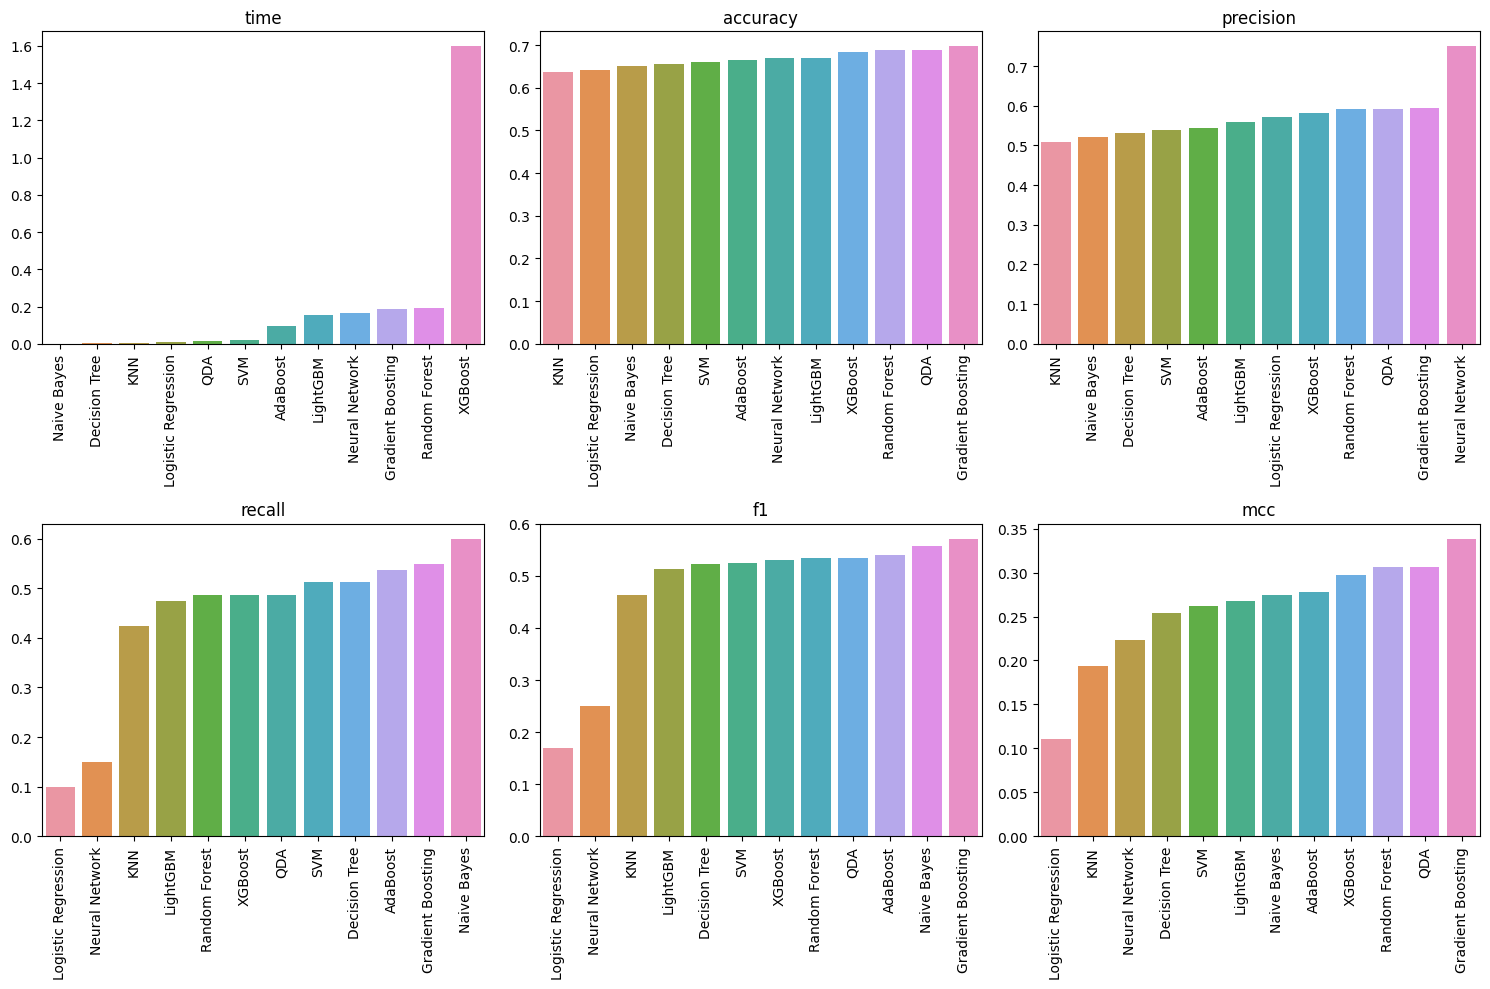

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# List of metrics
metrics = ['time', 'accuracy', 'precision', 'recall', 'f1', 'mcc']
labels = ['Time', 'Scores', 'Scores', 'Scores', 'Scores', 'Scores']

# plot metrics
for i, metric in enumerate(metrics):
    row = i // 3 # Integer division to convert i into a row index
    col = i % 3 # Modulo division to convert i into a column index
    ax = axs[row, col]
    df_sorted = df_results.sort_values(metric)  # sort by the current metric
    sns.barplot(data=df_sorted, x='name', y=metric, ax=ax) 
    ax.set_xticklabels(df_sorted['name'], rotation=90)  # set x-tick labels to the names in the sorted df
    ax.set_title(metric)
    ax.set_xlabel('')  
    ax.set_ylabel('')  

plt.tight_layout()
plt.show()




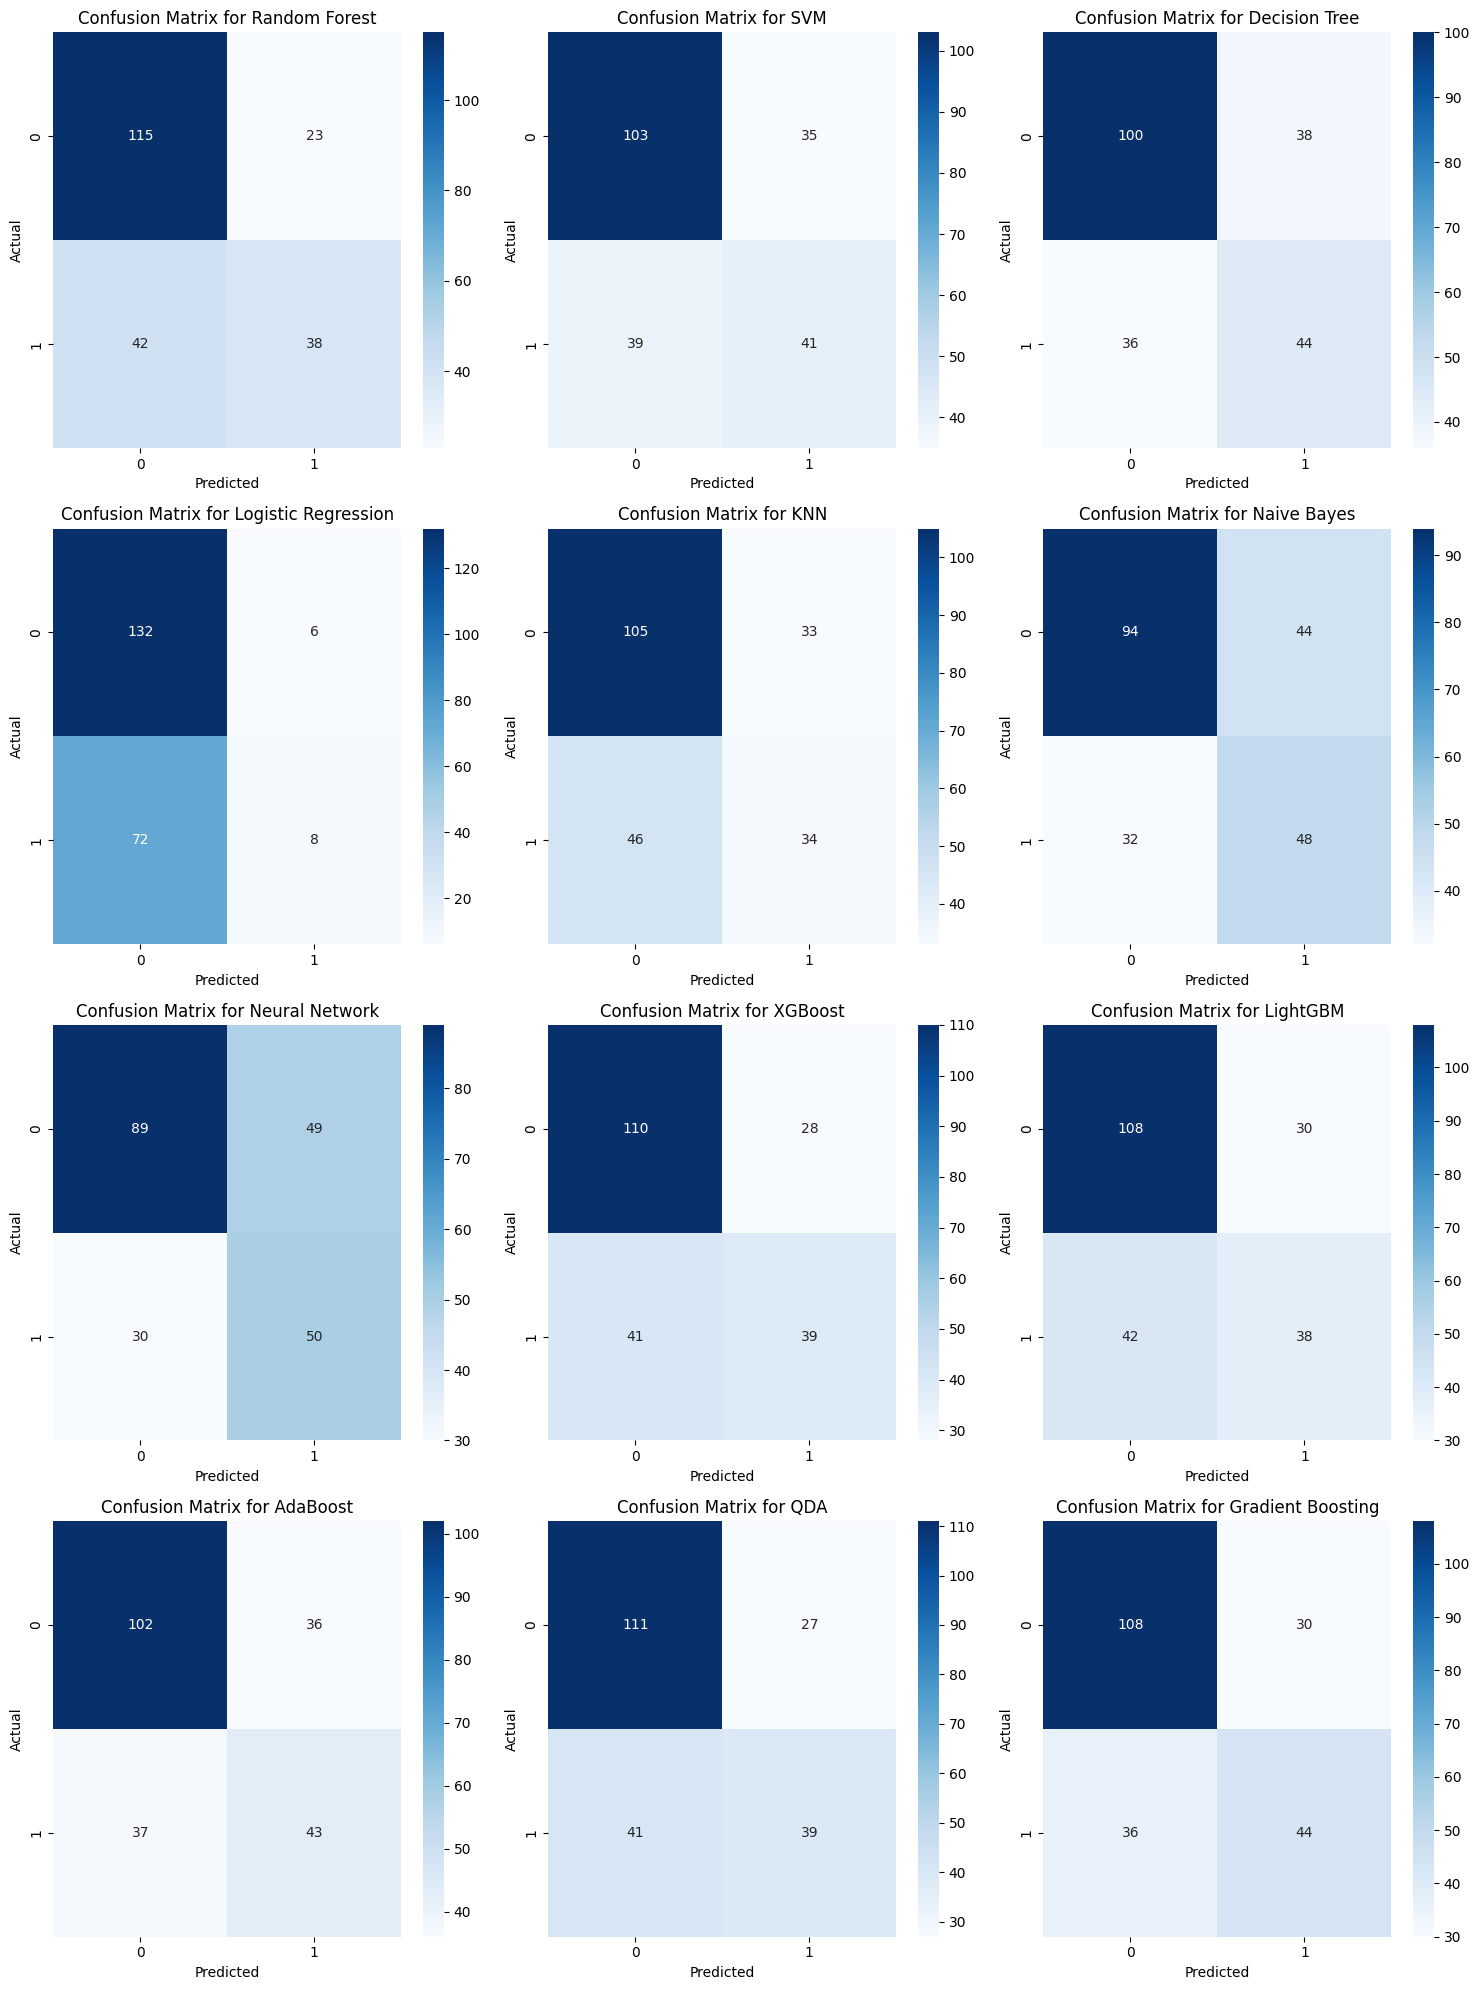

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# ensure that the number of subplots matches the number of models
assert len(axs.flatten()) >= len(results)

# confusion matrix for each model
for i, result in enumerate(results):
    ax = axs.flatten()[i]

    name = result['name']
    cm = result['confusion_matrix']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix for {name}')

# hide the extra subplots
for j in range(i+1, len(axs.flatten())):
    axs.flatten()[j].axis('off')

plt.tight_layout()
plt.show()


